In [11]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import geopandas as gpd

In [12]:
past_df = pd.read_csv("Crime_Data_from_2010_to_2019.csv")
# https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8
present_df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")

LAPD_df = pd.read_csv("LAPD_Police_Stations.csv")

# past dataset has column name typo
past_df = past_df.rename(columns={"AREA ": "AREA"})

# Both datasets use the same columns 
df = pd.concat([past_df, present_df])

In [13]:
df = df.drop(columns=[
    "Crm Cd", "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", 
    "Crm Cd 4", "Premis Cd", "Weapon Used Cd", 
    "Mocodes", "Part 1-2", "Status", "Date Rptd"
    ])

# Changed code to be readable description
df["Vict Descent"] = df["Vict Descent"].replace({
                            "A": "Other Asian", 
                            "B": "Black", 
                            "C": "Chinese", 
                            "D": "Cambodian", 
                            "F": "Filipino", 
                            "G": "Guamanian", 
                            "H": "Hispanic/Latin/Mexican", 
                            "I": "American Indian/Alaskan Native", 
                            "J": "Japanese", 
                            "K": "Korean", 
                            "L": "Laotian", 
                            "O": "Other", 
                            "P": "Pacific Islander", 
                            "S": "Samoan", 
                            "U": "Hawaiian", 
                            "V": "Vietnamese", 
                            "W": "White", 
                            "X": "Unknown", 
                            "Z": "Asian Indian",
                        })

# Renamed X,Y to Longitude, Latitude
LAPD_df = LAPD_df.rename(columns={
    "X": "Longitude", 
    "Y": "Latitude"
    })

In [14]:
df.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,VIOLATION OF COURT ORDER,48,M,Hispanic/Latin/Mexican,SINGLE FAMILY DWELLING,NaN,Adult Arrest,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/12/2010 12:00:00 AM,45,14,Pacific,1485,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,White,STREET,NaN,Invest Cont,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,OTHER MISCELLANEOUS CRIME,0,M,Hispanic/Latin/Mexican,ALLEY,NaN,Invest Cont,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,150,6,Hollywood,646,VIOLATION OF COURT ORDER,47,F,White,STREET,HAND GUN,Invest Cont,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/02/2010 12:00:00 AM,2100,1,Central,176,"RAPE, ATTEMPTED",47,F,Hispanic/Latin/Mexican,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,8TH ST,SAN PEDRO ST,34.0387,-118.2488


Clustering the locations of where crimes occur will give us a general map of how the precints should be divided. In addition, the centers of the clusters would be the optimal locations to put police stations. In this case, we chose to use k-means clustering and we chose the number of clusters to be 21 since there are 21 police stations in LA. 

In [21]:
kmeans = KMeans(n_clusters=21)
kmeans.fit(df[["LON", "LAT"]])

KMeans(n_clusters=21)

After fitting K-means with the location data, we can then plot everything on a map of LA. In addition, we can also plot which cluster each point is part of which would relate to which station they belong to as well as mapping out the precinct lines.

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

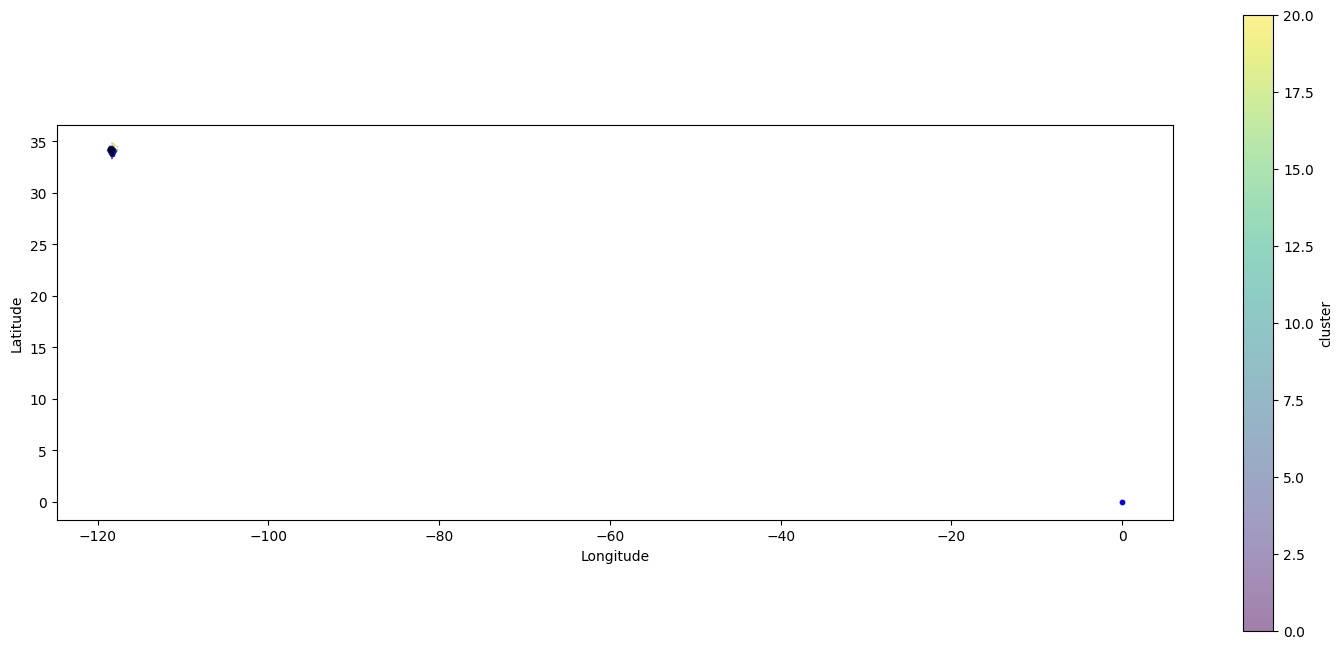

In [22]:
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=['Longitude', 'Latitude'])

map_df = gpd.read_file('LAPD_Divisions.shp')

fig, ax = plt.subplots(1, figsize = (18, 8))
map_df.boundary.plot(color='black', ax=ax)


# labeling each crime to a cluster
df["cluster"] = kmeans.predict(df[["LON", "LAT"]])
df.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='cluster',  s=0.1, alpha=0.5, cmap='viridis')


LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='orange')
centers_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='blue') 

The graph shows two random dots and does not have a map of LA. This was due to some points being labeled as 0,0 which is why k-means made them into a cluster. To ammend this, we have to filter the coordinates so that they are mapped to the area of LA

In [15]:
df_plot = df.loc[(df['LAT'] >= 33.7) & (df['LAT'] <= 34.37) & (df['LON'] >= -118.7) & (df['LON'] <= -118.15)]

In [16]:
df_plot.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,VIOLATION OF COURT ORDER,48,M,Hispanic/Latin/Mexican,SINGLE FAMILY DWELLING,NaN,Adult Arrest,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/12/2010 12:00:00 AM,45,14,Pacific,1485,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,White,STREET,NaN,Invest Cont,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,OTHER MISCELLANEOUS CRIME,0,M,Hispanic/Latin/Mexican,ALLEY,NaN,Invest Cont,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,150,6,Hollywood,646,VIOLATION OF COURT ORDER,47,F,White,STREET,HAND GUN,Invest Cont,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/02/2010 12:00:00 AM,2100,1,Central,176,"RAPE, ATTEMPTED",47,F,Hispanic/Latin/Mexican,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,8TH ST,SAN PEDRO ST,34.0387,-118.2488


<AxesSubplot: >

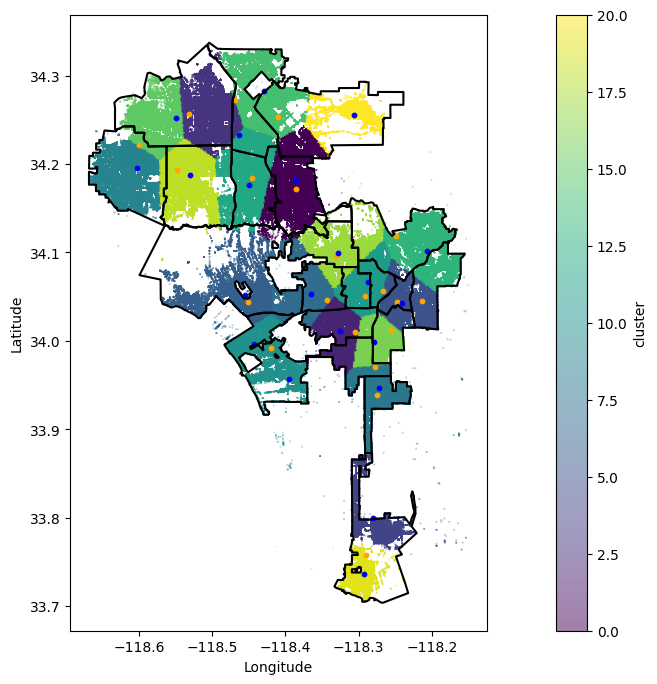

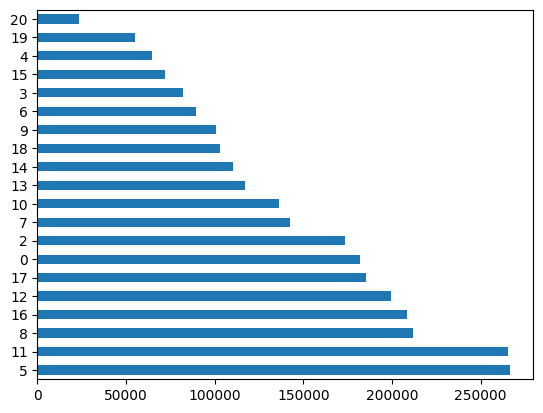

In [33]:
fig, ax = plt.subplots(1, figsize = (18, 8))
map_df.boundary.plot(color='black', ax=ax)


# df_test["cluster"] = agg_cluster.predict(df_test[["LON", "LAT"]])
df_plot.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='cluster',  s=0.1, alpha=0.5, cmap='viridis')


LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='orange')
centers_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='blue') 


fig, ax = plt.subplots(1)
df_plot["cluster"].value_counts().plot(kind="barh")

<AxesSubplot: xlabel='LON', ylabel='LAT'>

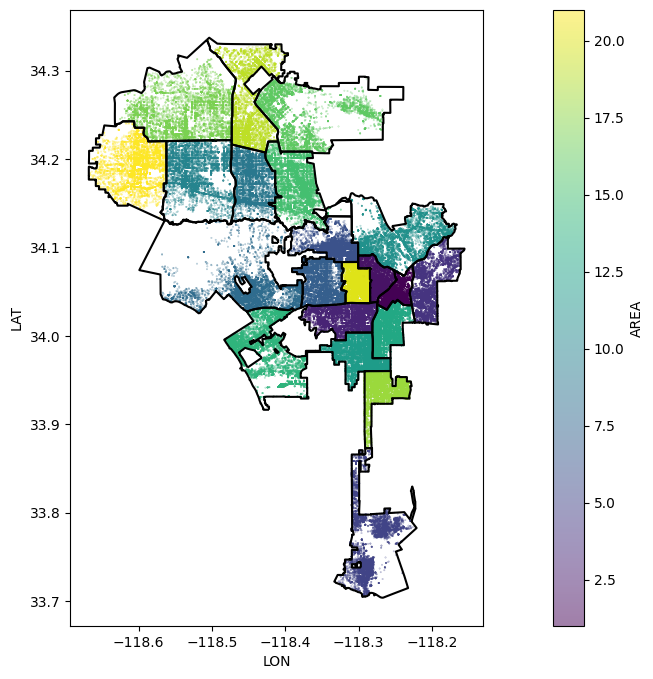

In [24]:
fig, ax = plt.subplots(1, figsize = (18, 8))
map_df.boundary.plot(color='black', ax=ax)
df_test.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='AREA',  s=0.1, alpha=0.5, cmap='viridis')

In [8]:
kmeans = KMeans(n_clusters=21)
kmeans.fit(df_plot[["LON", "LAT"]])

KMeans(n_clusters=21)

C:\Users\Alex\AppData\Local\Temp\ipykernel_11600\2437674564.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["cluster"] = kmeans.predict(df_plot[["LON", "LAT"]])


<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

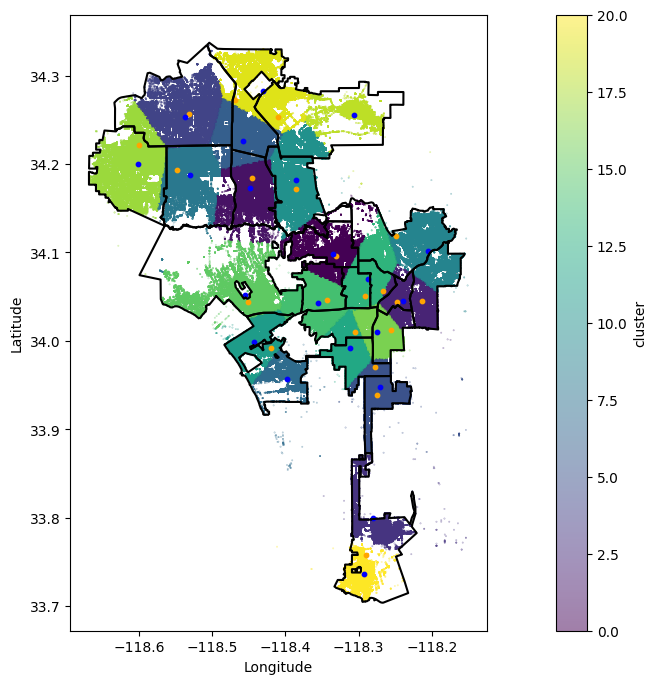

In [9]:
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=['Longitude', 'Latitude'])

fig, ax = plt.subplots(1, figsize = (18, 8))
map_df.boundary.plot(color='black', ax=ax)



df_plot["cluster"] = kmeans.predict(df_plot[["LON", "LAT"]])
df_plot.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='cluster',  s=0.1, alpha=0.5, cmap='viridis')


LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='orange')
centers_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='blue') 

We can see that some centers from k-means are actually fairly close to actual police stations. In addition we can see borders of how each precint should be mapped based on k-means clustering.

Now we check if this has made the distribution of crime per station more even

<AxesSubplot: >

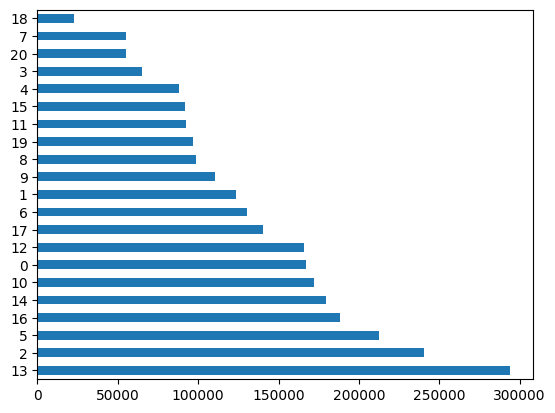

In [10]:
df_plot["cluster"].value_counts().plot(kind="barh")

<AxesSubplot: >

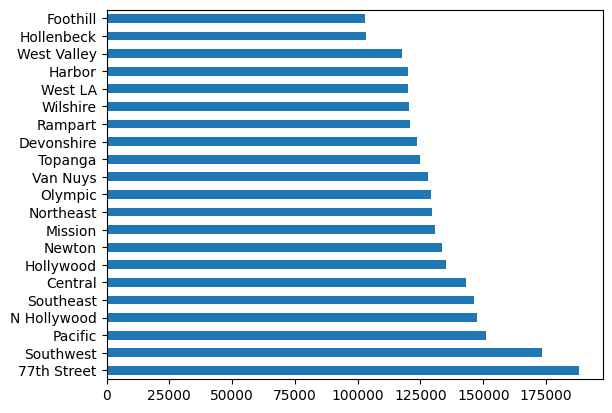

In [11]:
df_plot["AREA NAME"].value_counts().plot(kind="barh")

However, it seems that k-means has actually made the distribution worse as there are now larger differences between stations. K-means did not give us centers that would equally distribute crimes.

Another idea to try is maybe there are too much police stations in LA. What we can do is reduce the number of clusters k-means has to make.

In [12]:
def cluster_la_crime(num_clusters):
    kmeans = KMeans(n_clusters = num_clusters)
    kmeans.fit(df_plot[["LON", "LAT"]])

    centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=['Longitude', 'Latitude'])

    fig, ax = plt.subplots(1, figsize = (18, 8))
    map_df.boundary.plot(color='black', ax=ax)



    df_plot["cluster"] = kmeans.predict(df_plot[["LON", "LAT"]])
    df_plot.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='cluster',  s=0.1, alpha=0.5, cmap='viridis')


    LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='orange')
    centers_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='blue') 

    fig, ax = plt.subplots(1)
    df_plot["cluster"].value_counts().plot(kind="barh")

Num clusters = 5

C:\Users\Alex\AppData\Local\Temp\ipykernel_11600\2418307921.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["cluster"] = kmeans.predict(df_plot[["LON", "LAT"]])


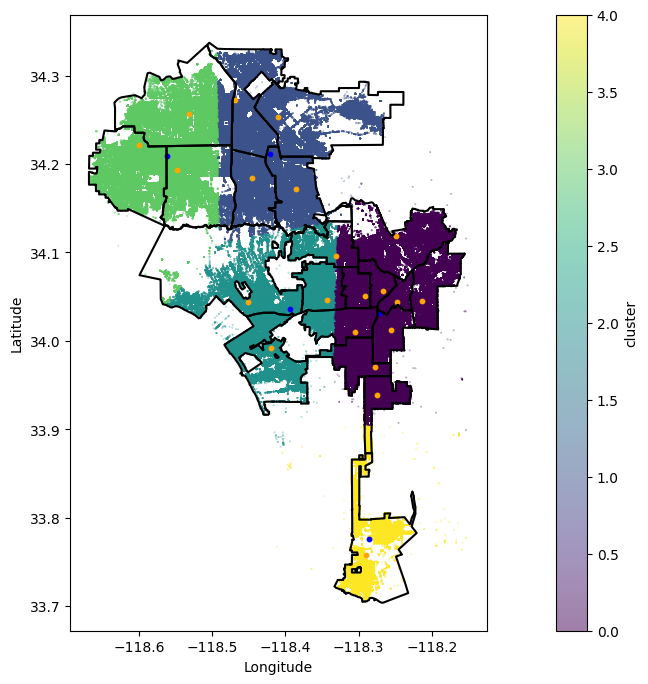

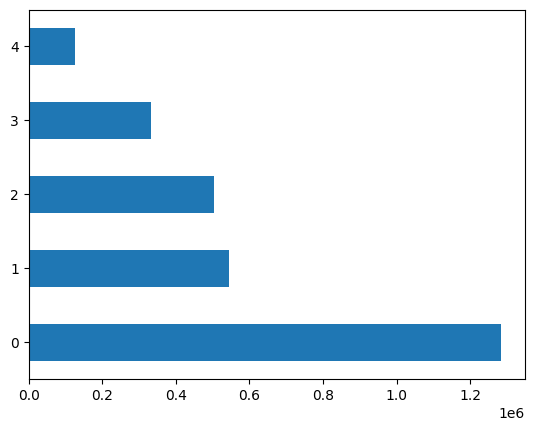

In [13]:
cluster_la_crime(5)

Num clusters = 10

C:\Users\Alex\AppData\Local\Temp\ipykernel_11600\2418307921.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["cluster"] = kmeans.predict(df_plot[["LON", "LAT"]])


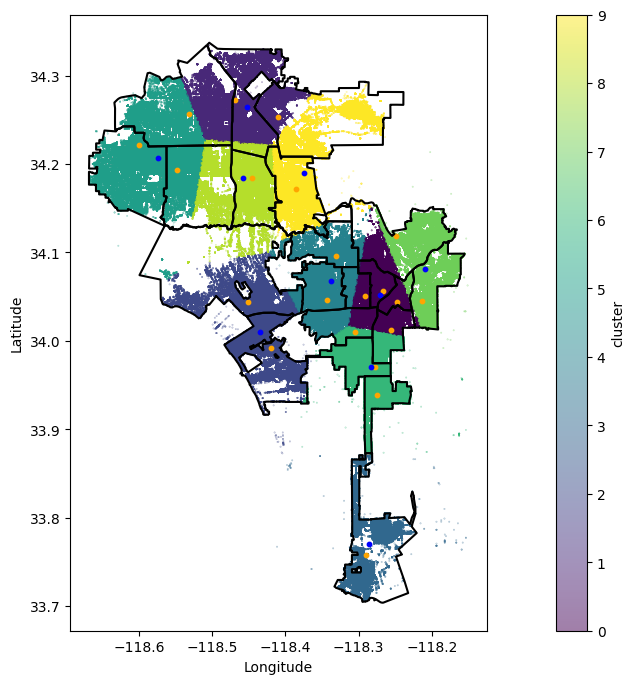

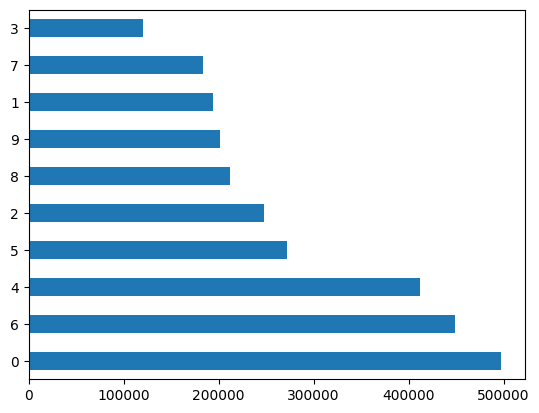

In [14]:
cluster_la_crime(10)

Num clusters = 15

C:\Users\Alex\AppData\Local\Temp\ipykernel_11600\2418307921.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["cluster"] = kmeans.predict(df_plot[["LON", "LAT"]])


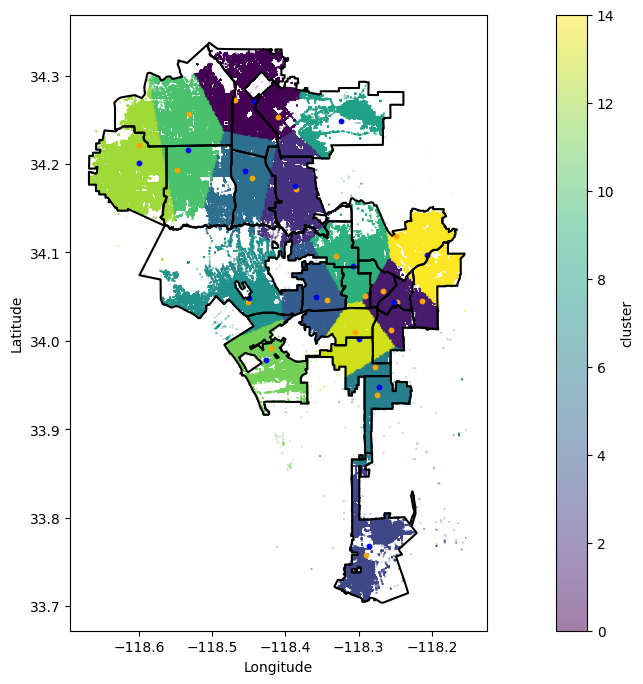

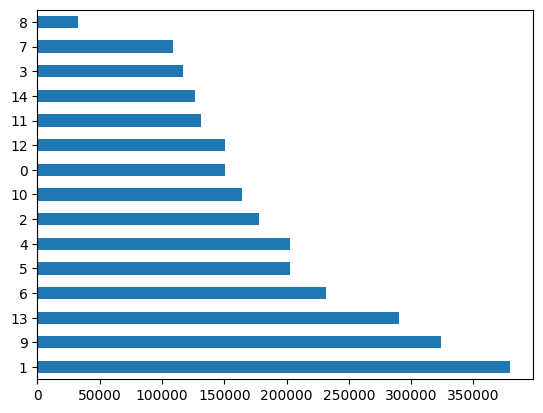

In [15]:
cluster_la_crime(15)

So reducing the number of clusters did not help. Maybe increasing the number of clusters will be better?

Num clusters = 30

C:\Users\Alex\AppData\Local\Temp\ipykernel_11600\2418307921.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["cluster"] = kmeans.predict(df_plot[["LON", "LAT"]])


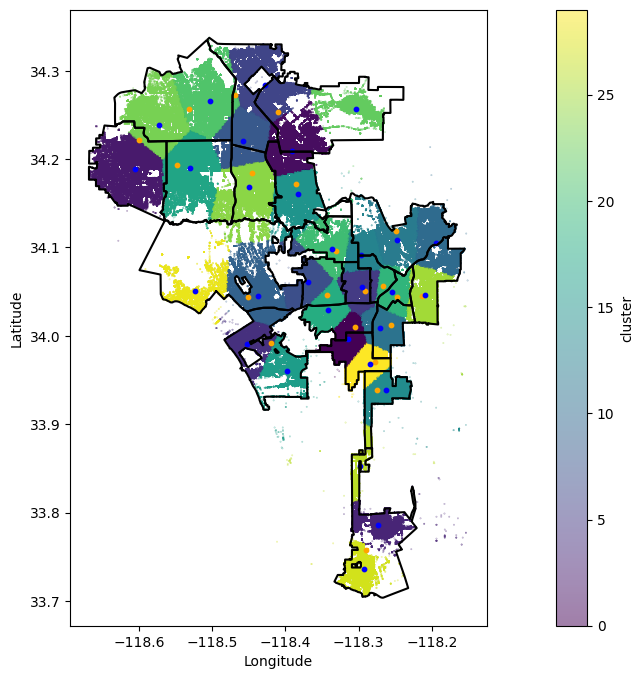

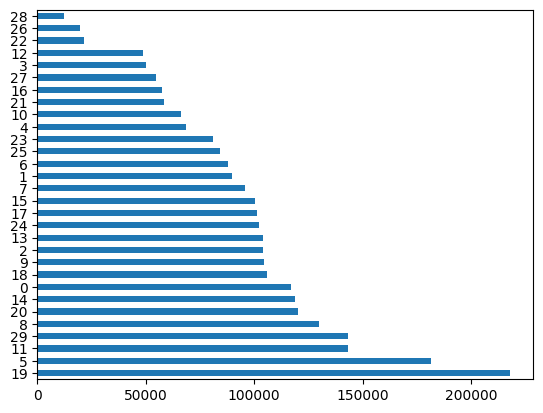

In [16]:
cluster_la_crime(30)

Num clusters = 40

C:\Users\Alex\AppData\Local\Temp\ipykernel_11600\2418307921.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["cluster"] = kmeans.predict(df_plot[["LON", "LAT"]])


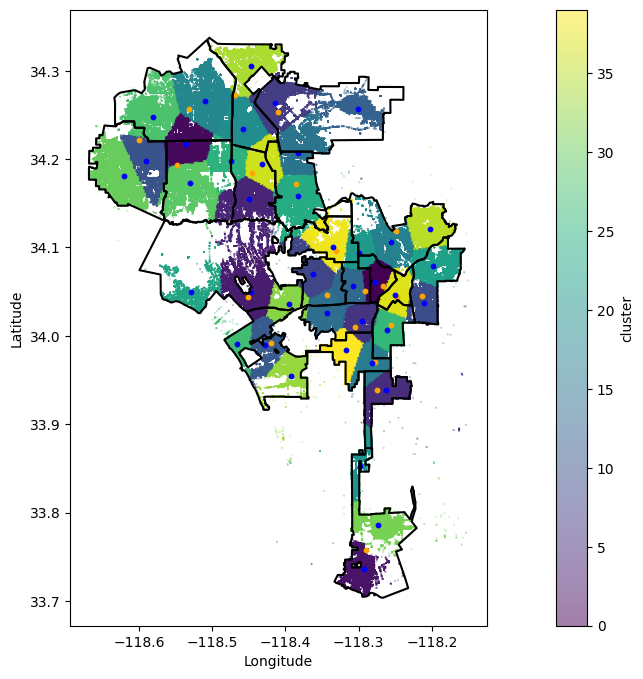

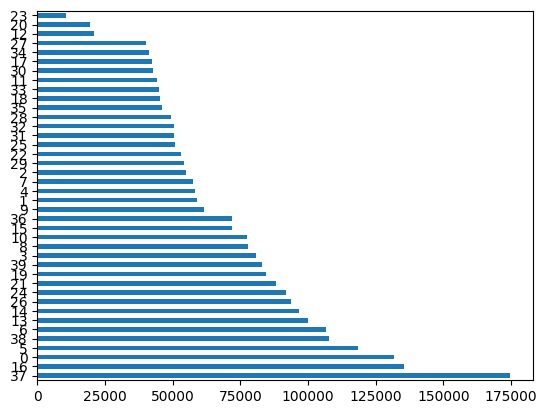

In [17]:
cluster_la_crime(40)

Num clusters = 50

C:\Users\Alex\AppData\Local\Temp\ipykernel_11600\2418307921.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["cluster"] = kmeans.predict(df_plot[["LON", "LAT"]])


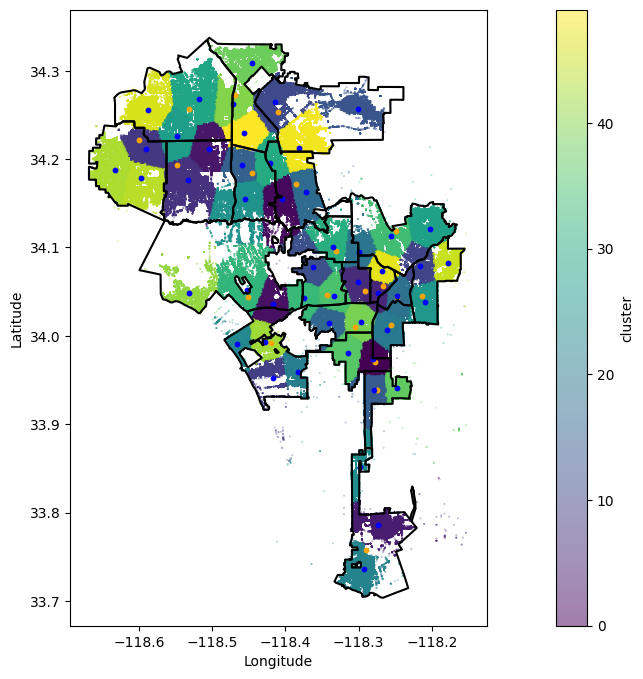

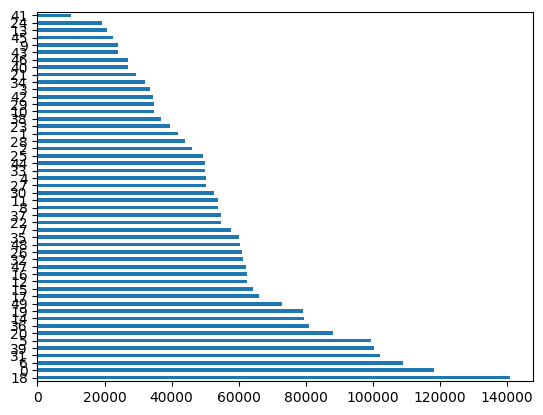

In [18]:
cluster_la_crime(50)

From the graphs, it seems that k-means will not give equal distributions of crime. 

Idea here is to basically train K-means on past years and then test it on a full year to see if it distributes crime evenly

In [12]:
df_plot["DATE OCC"] = pd.to_datetime(df_plot["DATE OCC"])

C:\Users\Alex\AppData\Local\Temp\ipykernel_3016\4043744685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["DATE OCC"] = pd.to_datetime(df_plot["DATE OCC"])


In [44]:
df_train = df_plot[df_plot["DATE OCC"].dt.year <= 2021]
df_test = df_plot[df_plot["DATE OCC"].dt.year == 2022]

In [45]:
kmeans = KMeans(n_clusters=21)
kmeans.fit(df_train[["LON", "LAT"]])

KMeans(n_clusters=21)

C:\Users\Alex\AppData\Local\Temp\ipykernel_3016\507467193.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["cluster"] = kmeans.predict(df_train[["LON", "LAT"]])


<AxesSubplot: >

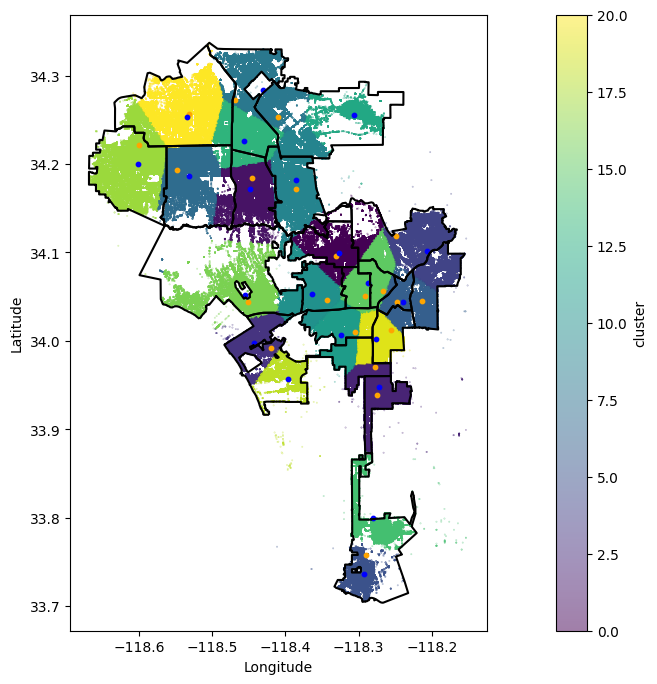

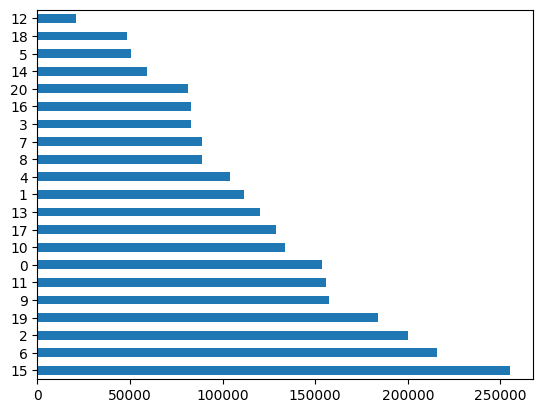

In [46]:
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=['Longitude', 'Latitude'])

fig, ax = plt.subplots(1, figsize = (18, 8))
map_df.boundary.plot(color='black', ax=ax)



df_train["cluster"] = kmeans.predict(df_train[["LON", "LAT"]])
df_train.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='cluster',  s=0.1, alpha=0.5, cmap='viridis')


LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='orange')
centers_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='blue') 


fig, ax = plt.subplots(1)
df_train["cluster"].value_counts().plot(kind="barh")

C:\Users\Alex\AppData\Local\Temp\ipykernel_3016\2032434185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["cluster"] = kmeans.predict(df_test[["LON", "LAT"]])


<AxesSubplot: >

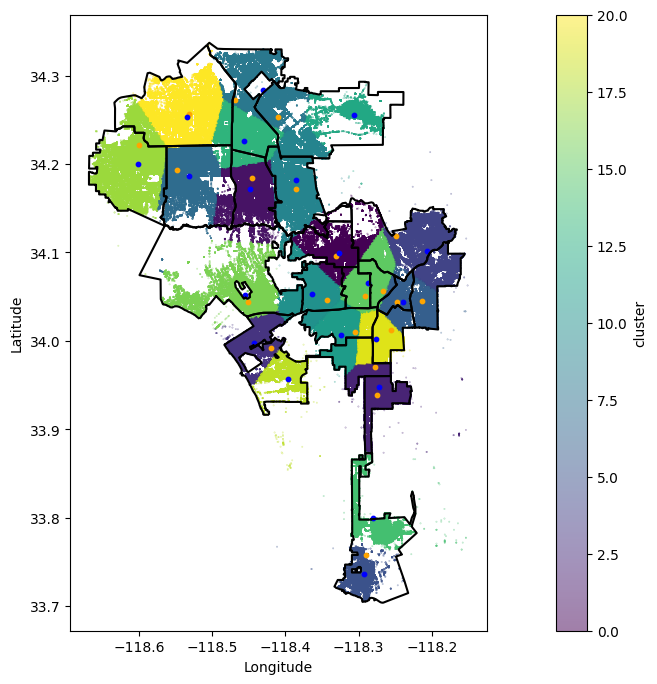

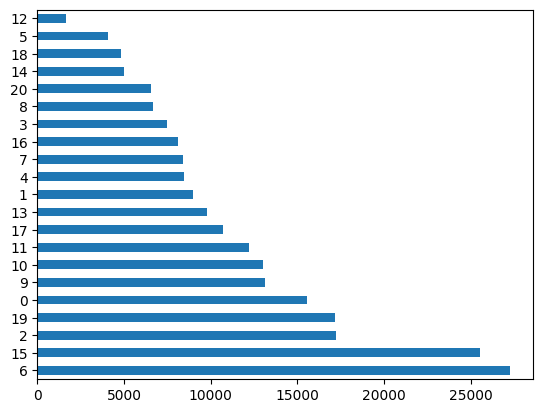

In [47]:
fig, ax = plt.subplots(1, figsize = (18, 8))
map_df.boundary.plot(color='black', ax=ax)


df_test["cluster"] = kmeans.predict(df_test[["LON", "LAT"]])
df_train.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='cluster',  s=0.1, alpha=0.5, cmap='viridis')


LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='orange')
centers_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='blue')


fig, ax = plt.subplots(1)
df_test["cluster"].value_counts().plot(kind="barh")

<AxesSubplot: >

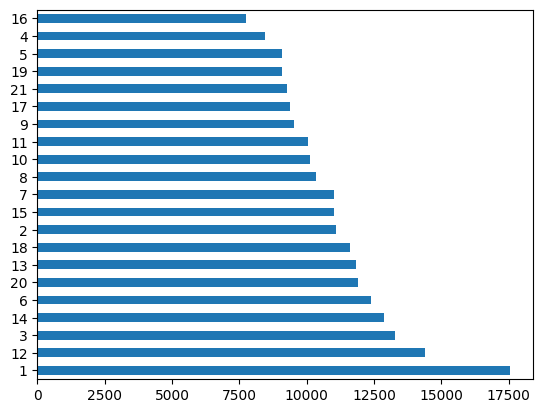

In [48]:
df_test["AREA"].value_counts().plot(kind="barh")

In [23]:
df_plot.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,VIOLATION OF COURT ORDER,48,M,Hispanic/Latin/Mexican,SINGLE FAMILY DWELLING,NaN,Adult Arrest,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/12/2010 12:00:00 AM,45,14,Pacific,1485,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0,M,White,STREET,NaN,Invest Cont,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,OTHER MISCELLANEOUS CRIME,0,M,Hispanic/Latin/Mexican,ALLEY,NaN,Invest Cont,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,150,6,Hollywood,646,VIOLATION OF COURT ORDER,47,F,White,STREET,HAND GUN,Invest Cont,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/02/2010 12:00:00 AM,2100,1,Central,176,"RAPE, ATTEMPTED",47,F,Hispanic/Latin/Mexican,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,8TH ST,SAN PEDRO ST,34.0387,-118.2488


In [51]:
df_plot["Weapon Desc"].unique()

array([nan, 'HAND GUN', 'STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)',
       'UNKNOWN WEAPON/OTHER WEAPON', 'VERBAL THREAT', 'SIMULATED GUN',
       'FOLDING KNIFE', 'OTHER KNIFE', 'MACE/PEPPER SPRAY', 'STICK',
       'UNKNOWN FIREARM', 'SWITCH BLADE',
       'KNIFE WITH BLADE 6INCHES OR LESS', 'BOARD', 'BLUNT INSTRUMENT',
       'SEMI-AUTOMATIC PISTOL', 'VEHICLE', 'OTHER CUTTING INSTRUMENT',
       'SCISSORS', 'BOTTLE', 'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH',
       'BELT FLAILING INSTRUMENT/CHAIN',
       'AUTOMATIC WEAPON/SUB-MACHINE GUN', 'CLUB/BAT', 'BRASS KNUCKLES',
       'KITCHEN KNIFE', 'AIR PISTOL/REVOLVER/RIFLE/BB GUN', 'SCREWDRIVER',
       'FIRE', 'STUN GUN', 'RIFLE', 'RAZOR BLADE', 'DIRK/DAGGER',
       'CAUSTIC CHEMICAL/POISON', 'SHOTGUN', 'ICE PICK', 'BOMB THREAT',
       'ROCK/THROWN OBJECT', 'REVOLVER', 'OTHER FIREARM', 'DEMAND NOTE',
       'BOWIE KNIFE', 'HECKLER & KOCH 93 SEMIAUTOMATIC ASSAULT RIFLE',
       'SCALDING LIQUID', 'ROPE/LIGATURE', 'MACHETE', 'T

# Calculatiing crimes near police station

In [39]:
# merging crimes with LA police station. This is to get location of crime with location of the associated police station
df_merged = df_plot.merge(LAPD_df, left_on = "AREA", right_on = "PREC")

In [6]:
import numpy as np

In [40]:
# Distance calculator between crime and police station
df_merged["distance"] = np.sqrt((df_merged["LAT"] - df_merged["Latitude"])**2 + (df_merged["LON"] - df_merged["Longitude"])**2)

In [41]:
# Determine which crime was done near a police station
# vazue of 0.0355 was gotten from https://forest.moscowfsl.wsu.edu/fswepp/rc/milatcon.html 
# what i did was just calculate latitude and longitude change 1 mile north and east. This should be the same as 
# 1 mile diagonally (aka radius). If its less than 0.0355, then it is within 1 mile of the police station
df_merged["near_police"] = df_merged["distance"] < 0.0355

In [43]:
# count of crimes that were near police station
df_merged["near_police"].value_counts()

True     1931934
False     857783
Name: near_police, dtype: int64

<AxesSubplot: ylabel='AREA NAME,near_police'>

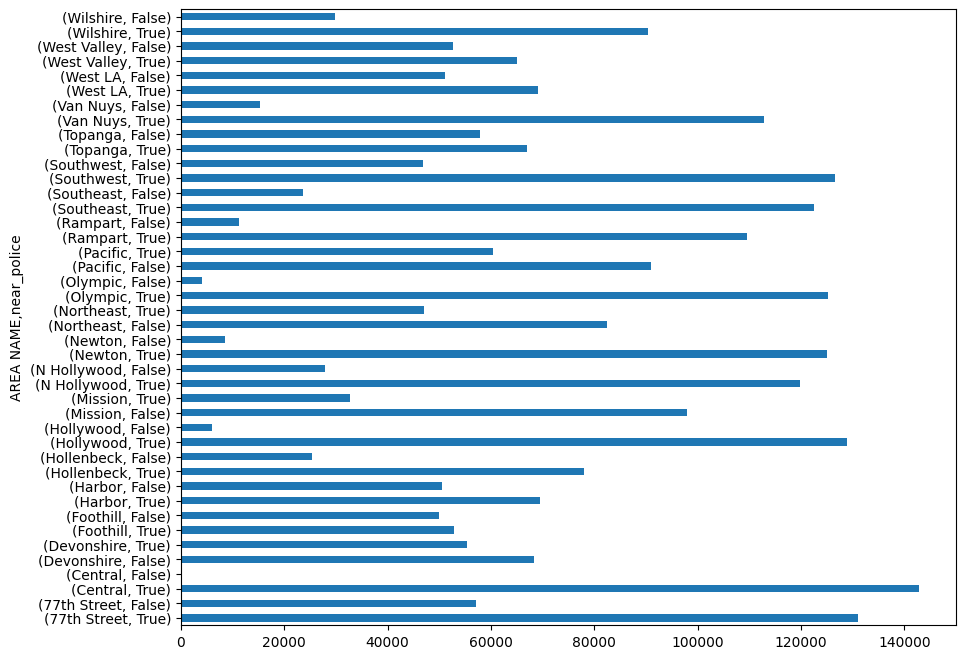

In [38]:
# plot of crimes near and away from their respective police station
fig, ax = plt.subplots(1, figsize = (10, 8))
df_merged.groupby("AREA NAME")["near_police"].value_counts().plot(kind="barh")

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

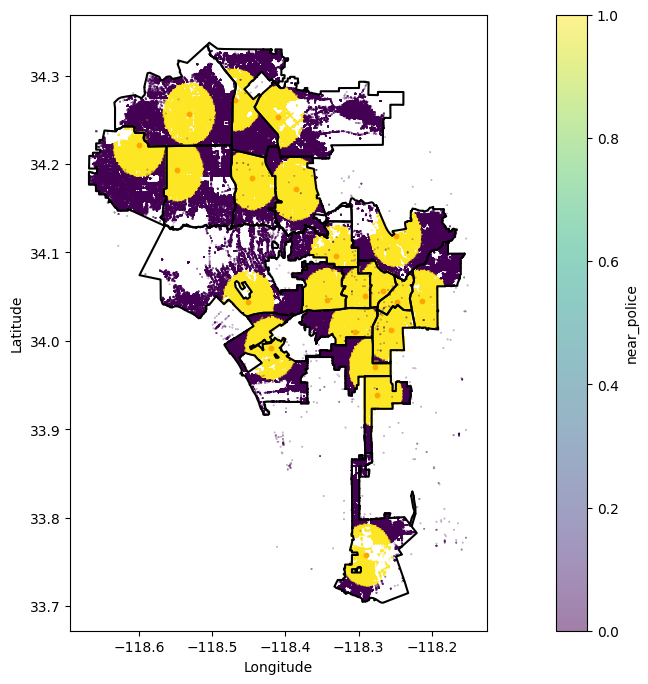

In [44]:
# converting column to int so that it can be plotted
df_merged["near_police"] = df_merged["near_police"].astype(int)

fig, ax = plt.subplots(1, figsize = (18, 8))
map_df.boundary.plot(color='black', ax=ax)


df_merged.plot(ax=ax, x='LON', y='LAT', kind='scatter', c='near_police',  s=0.1, alpha=0.5, cmap='viridis')


LAPD_df.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', s=10, c='orange')